In [13]:
import os
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
from statistics import  mean
import math
import time
from typing import Union
import tqdm

%matplotlib qt

In [2]:
HOME = os.environ['HOME']

## Creating Dataframe

In [3]:
def create_df(dpath:str)->pd.DataFrame:
    '''
    Creates a pandas dataframe from all the 
    pickled files
    '''
    data = pd.DataFrame(columns=['Time','Name','Model',
                                'GPS','Speed','BS'])

    for count,filename in enumerate(os.listdir(dpath)):
        ind = count
        with open(dpath+f'/{filename}','rb') as a:
            data.at[ind,'Time'] = pickle.load(a)
            data.at[ind,'Name'] = pickle.load(a)
            data.at[ind,'Model'] = pickle.load(a)
            data.at[ind,'GPS'] = pickle.load(a)
            data.at[ind,'Speed'] = pickle.load(a)
            data.at[ind,'BS'] = pickle.load(a)
        
        if (count+1)%1000 == 0:
            print(f'{count+1} samples has been added to dataframe')

    return data


In [4]:
try: 
    data = pd.read_pickle(f'{HOME}/webots_code/data/final/gps.pkl')
    print(f'Preprocessed dataframe already present')
except:
    dpath = f'{HOME}/webots_code/data/rt/data'
    print(f'Creating Dataframe .....')
    data = create_df(dpath)
    data.to_pickle(f'{HOME}/webots_code/data/rt/gps.pkl')
    print('Dataframe saved')

Preprocessed dataframe already present


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14902 entries, 0 to 14901
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    14902 non-null  object
 1   Name    14902 non-null  object
 2   Model   14902 non-null  object
 3   GPS     14902 non-null  object
 4   Speed   14902 non-null  object
 5   Lidar   14902 non-null  object
 6   BS      14902 non-null  object
dtypes: object(7)
memory usage: 931.4+ KB


In [6]:
ncars = len(data['Name'].unique())

## Distribution of samples 

In [23]:
# Number of samples per car
car_dist = data['Name'].value_counts().to_dict()
#Sorting into list
per_car = [car_dist[f'SUMO vehicle {i}'] for i in range(0,len(data['Name'].unique()))]

# plt.rcParams['figure.figsize'] = [20, 8]
# plt.rcParams['figure.dpi'] = 100 
plt.xlabel('Vehicle Index (0 Indexed)')
plt.ylabel('Number of samples collected per vehicle')
# plt.title('Distribution of samples over total vehicles')
plt.bar(range(0,len(data['Name'].unique())),per_car)

<BarContainer object of 57 artists>

## Average Speed and speed distribution

In [8]:
speed = dict()
speed_dist = [0]*(round(data['Speed'][data['Speed']<100].max())+1)
for i in data.index.values:
    if data.at[i,'Speed'] > 100.00:
        print('Unusually high speed:',data.at[i,'Speed'],'Skipping')
        continue
    if data.at[i,'Name'] in speed.keys():
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    else:
        speed[data.at[i,'Name']] = list()
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    speed_dist[round(data.at[i,'Speed'])]+=1

Unusually high speed: 78123.74630184326 Skipping
Unusually high speed: 78577.19204316252 Skipping
Unusually high speed: 78129.38644345499 Skipping
Unusually high speed: 78690.58612413231 Skipping
Unusually high speed: 78361.25566322099 Skipping
Unusually high speed: 78566.60769535151 Skipping


### Speed Distribution

Max speed is 17.67503567392118


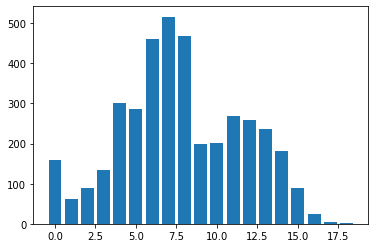

In [9]:
# plt.rcParams['figure.figsize'] = [15, 8]
# plt.rcParams['figure.dpi'] = 100
plt.bar(range(len(speed_dist)),speed_dist[:20])
print('Max speed is',data['Speed'][data['Speed']<100].max())

In [10]:
avg_speed = list()
for i in range(len(data['Name'].unique())):
    avg_speed.append(mean(speed[f'SUMO vehicle {i}']))

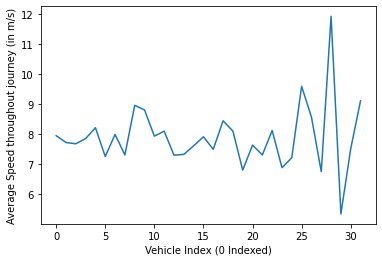

In [11]:
# plt.rcParams['figure.figsize'] = [20, 8]
# plt.rcParams['figure.dpi'] = 100
plt.xlabel('Vehicle Index (0 Indexed)')
plt.ylabel('Average Speed throughout journey (in m/s)')
# plt.title('Average Speed Distribution Over Collected Data')
plt.plot(range(ncars),avg_speed)

## Surrounding vehicles

### For each sample
Calculating surrounding vehciles for each sample

In [9]:
timestep = 0.128
gpath = f'{HOME}/webots_code/data/final/gps'
lrange = 120

#Creating new column for veh count
veh_range = [0]*len(data)

In [13]:
# Determining the distance between car and transmitter in meter
# TO-DO : Consider height while calculating distance
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [14]:
def read_gps(gpath)-> Union[pd.DataFrame]:
    '''
    Read all the GPS dataset and store
    it in RAM, for faster exec
    '''
    gps_pd = []
    for filename in os.listdir(gpath):
        gps_pd.append(pd.read_feather(
                        gpath+f'/{filename}'))
    
    return gps_pd

In [15]:
gps_pd = read_gps(gpath)
print(len(gps_pd),gps_pd[0].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21468 entries, 0 to 21467
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timestep  21468 non-null  float64
 1   gps       21468 non-null  object 
 2   speed     21468 non-null  float64
 3   model     21468 non-null  object 
dtypes: float64(2), object(2)
memory usage: 671.0+ KB
32 None


In [16]:
data.at[0,'GPS']


[38.89429623716866, -77.07303298699297, 0.358]

In [10]:
data = pd.read_pickle(f'{HOME}/webots_code/data/final/stats_pd.pkl')

In [18]:
#Iterating over all the vehicle GPS data
start = time.time()
veh_dist = list()
for i in tqdm.tqdm_notebook(data.index.values):
    siml_time = data.at[i,'Time']
    i_dist = list()
    for gps_entry in gps_pd: 
        # Checking for the position of the vehicle in that timestep
        entry = gps_entry[
                    ((data.at[i,'Time'] - timestep) < gps_entry['timestep']) &
                    (gps_entry['timestep'] <= data.at[i,'Time'])
                    ]
        
        
        if entry.empty : 
            continue
        

        if len(entry) > 1:
            entry = entry[entry['timestep']==siml_time]
            
#         print(entry)
#         print(entry['gps'])
            
        # Calculating distance between vehicles
        dist = dist_gps(data.at[i,'GPS'],entry['gps'].values[0])
        dist = round(dist,2)
        if dist < lrange and dist!=0:
            veh_range[i] +=1         #For number of vehicles in range
            i_dist.append(dist) #Capturing the distance of each vehicle
    
    veh_dist.append(i_dist)

/home/mohit/anaconda3/envs/webots_ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/3943 [00:00<?, ?it/s]

In [19]:
data['veh_range'] = veh_range
data['veh_dist'] = veh_dist

### Load pre processed data

In [19]:
occr = [0]*(data['veh_range'].max()+1)

for i in data.index.values:
    occr[data.at[i,'veh_range']]+=1

plt.xlabel('Number of vehicles within the range(120 m)')
plt.ylabel('Number of samples present')
# plt.title('Distribution of Surrounding Vehicles over the collected data')
# plt.rcParams['figure.figsize'] = [20, 8]
# plt.rcParams['figure.dpi'] = 100
plt.bar(range(data['veh_range'].max()+1),occr)

<BarContainer object of 21 artists>

  0%|          | 0/3943 [00:00<?, ?it/s]

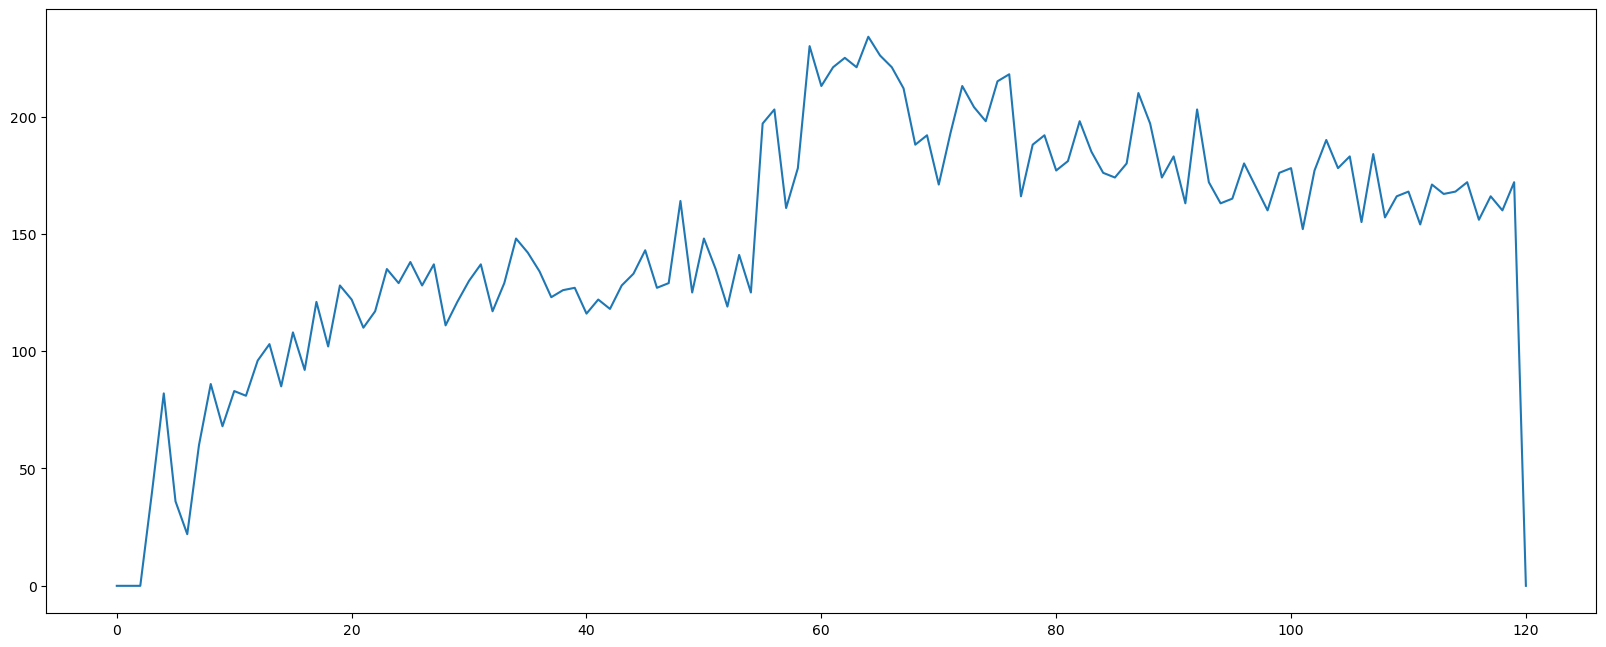

In [21]:
dist = [0]*121
start = time.time()
for i in tqdm.notebook.tqdm(data.index.values):
    for j in data.at[i,'veh_dist']:
        dist[int(j)] +=1
        
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(0,121),dist)

In [22]:
# # Saving dataframe
savepath = f'{HOME}/webots_code/data/rt/stats_pd.pkl'
data.to_pickle(savepath)

# No lidar

In [25]:
## Surrounding vehicles
### For each sample
timestep = 0.128
gpath = f'{HOME}/webots_code/data/rt/gps'
lrange = 120

In [26]:
# Determining the distance between car and transmitter in meter
# TO-DO : Consider height while calculating distance
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [27]:
def read_gps(gpath)-> Union[pd.DataFrame]:
    '''
    Read all the GPS dataset and store
    it in RAM, for faster exec
    '''
    gps_pd = []
    for filename in os.listdir(gpath):
        gps_pd.append(pd.read_feather(
                        gpath+f'/{filename}'))
    
    return gps_pd

In [28]:
gps_pd = read_gps(gpath)
print(len(gps_pd),gps_pd[0].head())

57    timestep                                             gps         speed  \
0    98.048    [38.98490574717039, -77.07634849024531, 0.5]  78128.906250   
1    98.176  [38.89358054338915, -77.07361753849344, 0.285]  79227.753057   
2    98.304  [38.89358054338915, -77.07361753849344, 0.285]      0.000000   
3    98.432  [38.89359693377051, -77.07362113611595, 0.285]     14.422849   
4    98.560  [38.89361332415167, -77.07362473374029, 0.285]     14.422849   

            model  
0  Citroen C-Zero  
1  Citroen C-Zero  
2  Citroen C-Zero  
3  Citroen C-Zero  
4  Citroen C-Zero  


In [33]:
#Iterating over all the vehicle GPS data
start = time.time()
veh_dist = list()
for i in tqdm.tqdm_notebook(data.index.values):
    siml_time = data.at[i,'Time']
    i_dist = list()
    for gps_entry in gps_pd: 
        # Checking for the position of the vehicle in that timestep
        entry = gps_entry[
                    ((data.at[i,'Time'] - timestep) < gps_entry['timestep']) &
                    (gps_entry['timestep'] <= data.at[i,'Time'])
                    ]
        
        
        if entry.empty : 
            continue
        

        if len(entry) > 1:
            entry = entry[entry['timestep']==siml_time]
            
        # Calculating distance between vehicles
        dist = dist_gps(data.at[i,'GPS'][1],entry['gps'].values[0])
        dist = round(dist,2)
        if dist < lrange and dist!=0:
            veh_range[i] +=1         #For number of vehicles in range
            i_dist.append(dist) #Capturing the distance of each vehicle
    
    veh_dist.append(i_dist)

/home/iiti/anaconda3/envs/webots/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/14902 [00:00<?, ?it/s]

In [34]:
data['veh_range'] = veh_range
data['veh_dist'] = veh_dist

<BarContainer object of 22 artists>

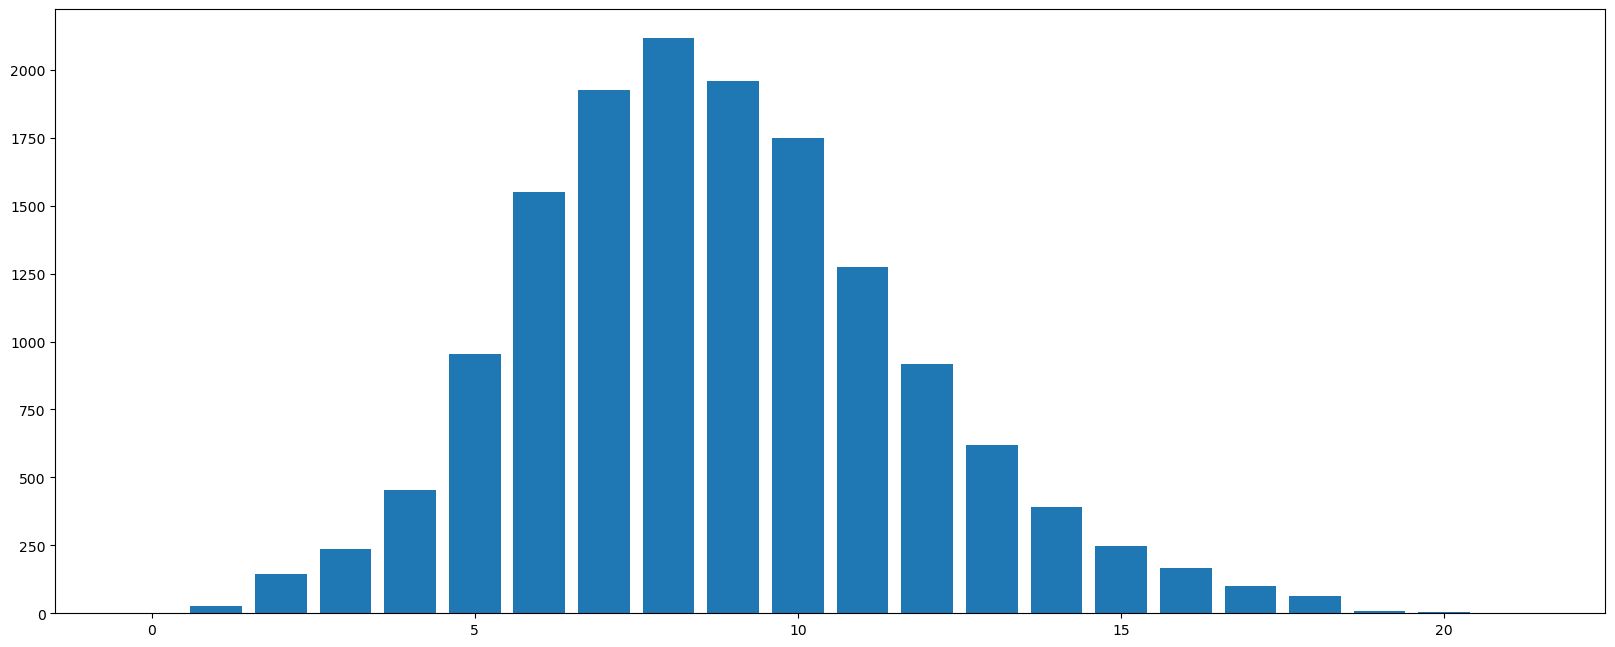

In [35]:
occr = [0]*(data['veh_range'].max()+1)

for i in data.index.values:
    occr[data.at[i,'veh_range']]+=1

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.bar(range(data['veh_range'].max()+1),occr)

  0%|          | 0/14902 [00:00<?, ?it/s]

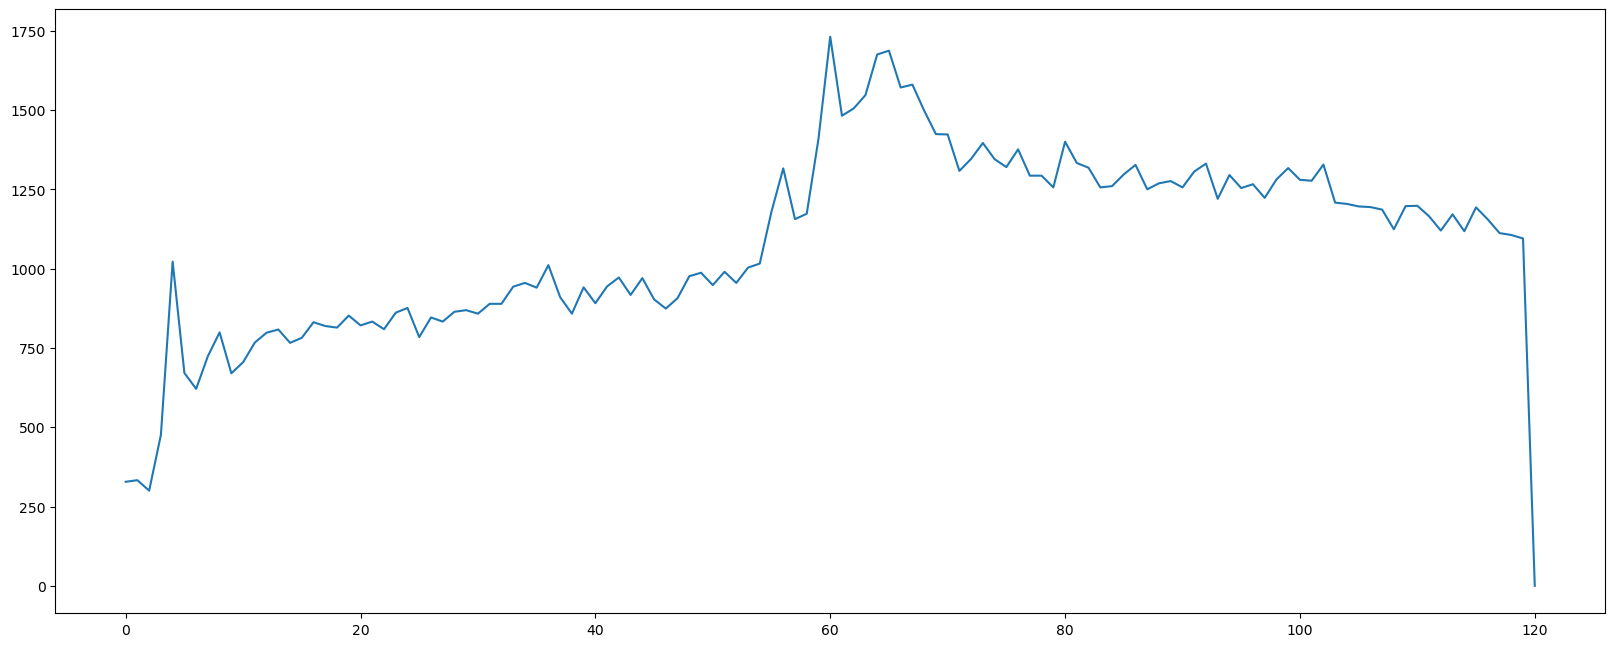

In [36]:
dist = [0]*121
start = time.time()
for i in tqdm.notebook.tqdm(data.index.values):
    for j in data.at[i,'veh_dist']:
        dist[int(j)] +=1
        
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(0,121),dist)

In [37]:
# # Saving dataframe
savepath = f'{HOME}/webots_code/data/final/stats_nl_pd.pkl'
data.to_pickle(savepath)